## Figure 5

MOA predictions

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "figure5")
extensions <- c(".png", ".pdf")

In [3]:
model_dir <- file.path("../2.MOA-prediction/L1000_CP_model_predictions/")
performance_dir <- file.path("../2.MOA-prediction/4.model_viz/performance_results")

In [4]:
# Load metrics results
metrics_file <- file.path(performance_dir, "all_performance_metrics.csv")

metrics_cols <- readr::cols(
    id_name = readr::col_character(),
    metrics = readr::col_character(),
    values = readr::col_double(),
    profile_tech = readr::col_character(),
    model = readr::col_character(),
    shuffle = readr::col_logical()
)

all_metrics_df <- readr::read_csv(metrics_file, col_types = metrics_cols)

# Process data
all_metrics_df$profile_tech <- dplyr::recode(
    all_metrics_df$profile_tech,
    `Cell painting` = "Cell Painting",
    `Cell painting subsample` = "Cell Painting (subsample)"
)
all_metrics_df$metrics <- dplyr::recode(
    all_metrics_df$metrics, `Precision-Recall_AUC` = "Precision-recall", `ROC_AUC` = "ROC"
)
all_metrics_df$metrics <- factor(all_metrics_df$metrics, levels = c("ROC", "Precision-recall"))
all_metrics_df$model <- factor(
    all_metrics_df$model,
    levels = c("Ml-KNN", "Simple NN", "1D-CNN", "ResNet", "TabNet", "Models Ensemble")
)
all_metrics_df$model <- dplyr::recode(
    all_metrics_df$model, `Models Ensemble` = "Ensemble"
)

In [5]:
head(all_metrics_df)

id_name,metrics,values,profile_tech,model,shuffle
<chr>,<fct>,<dbl>,<chr>,<fct>,<lgl>
CP_mlknn,Precision-recall,1.562936,Cell Painting,Ml-KNN,FALSE
CP_resnet,Precision-recall,11.339836,Cell Painting,ResNet,FALSE
CP_cnn,Precision-recall,10.653570,Cell Painting,1D-CNN,FALSE
CP_tabnet,Precision-recall,9.918287,Cell Painting,TabNet,FALSE
CP_simplenn,Precision-recall,11.324380,Cell Painting,Simple NN,FALSE
CP_blend,Precision-recall,11.803434,Cell Painting,Ensemble,FALSE


In [6]:
table(all_metrics_df$profile_tech)


            Cell Painting Cell Painting (subsample)     Cell painting & L1000 
                       22                        22                        22 
                    L1000 
                       22 

## Panel A

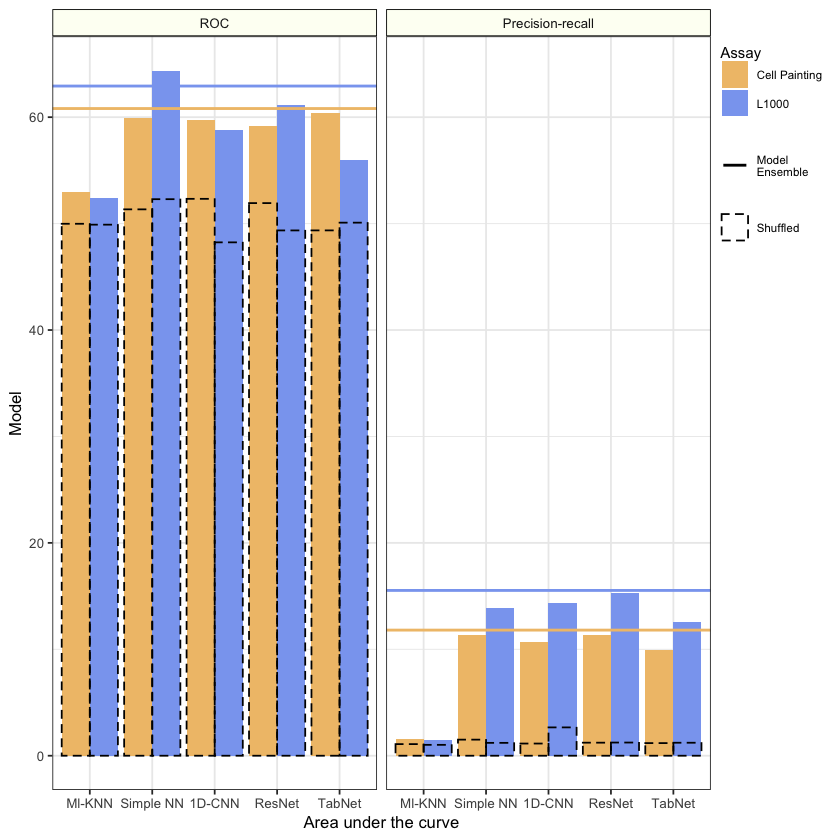

In [7]:
# Panel A
panel_a_df <- all_metrics_df %>%
    dplyr::filter(profile_tech %in% c("Cell Painting", "L1000"))

ensemble_df <- panel_a_df %>%
    dplyr::filter(model == "Ensemble")

panel_a_df <- panel_a_df %>%
    dplyr::filter(model != "Ensemble")

panel_a_gg <- (
    ggplot(data = NULL, aes(x = model, y = values))
    + geom_bar(
        data = panel_a_df %>% dplyr::filter(!shuffle),
        stat = "identity",
        aes(fill = profile_tech),
        position = "dodge"
    )
    + geom_bar(
        data = panel_a_df %>% dplyr::filter(shuffle),
        stat = "identity",
        aes(color = profile_tech),
        alpha = 0,
        position = "dodge",
        linetype = "dashed"
    )
    + figure_theme
    + theme(
        legend.spacing.y = unit(0.01, "cm"),
        legend.box.spacing = unit(0.01, "cm"),
        legend.justification = "top"
    )
    + scale_fill_manual("Assay", values = assay_colors)
    + scale_color_manual(breaks = "Cell Painting", name = "", values = c("black", "black"), labels = c("Shuffled"))
    + scale_linetype_manual(name = "", values = "solid", labels = "Model\nEnsemble")
    + geom_hline(data = ensemble_df, aes(yintercept = values, linetype = "Ensemble"), color = rep(paste(assay_colors), 2), lwd = 0.8)    
    + facet_wrap("~metrics")
    + xlab("Area under the curve")
    + ylab("Model")
    + guides(
        fill = guide_legend(order = 1),
        color = guide_legend(order = 3),
        linetype = guide_legend(order = 2)
    )
)

panel_a_gg

## Supplementary Fig

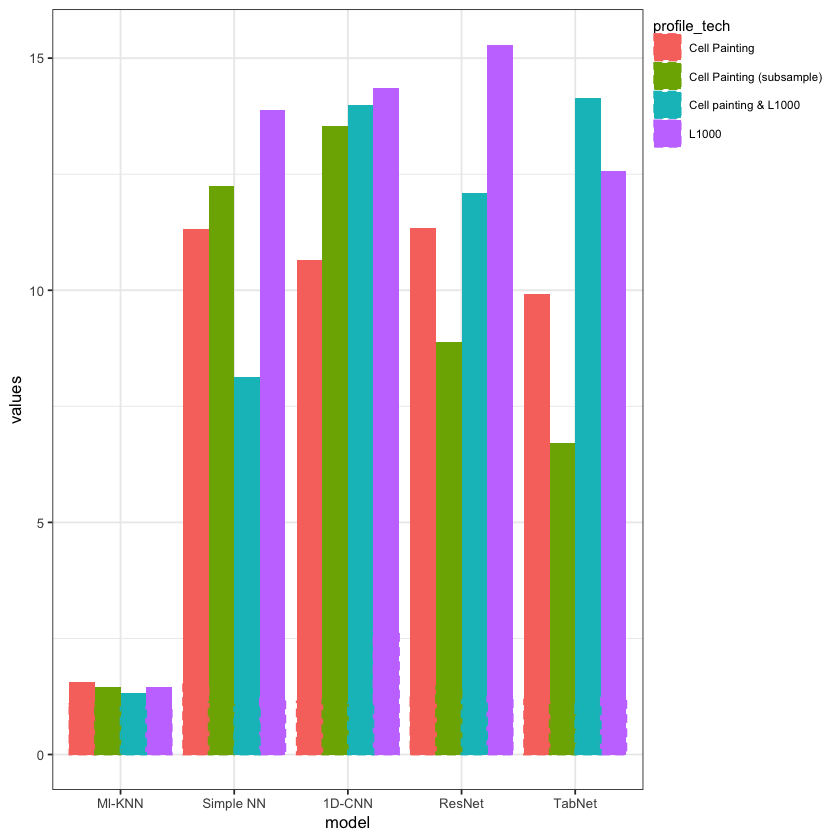

In [8]:
sup_panel_a_df <- all_metrics_df %>%
    dplyr::filter(metrics == "Precision-recall")

ensemble_df <- sup_panel_a_df %>%
    dplyr::filter(model == "Ensemble")

sup_panel_a_df <- sup_panel_a_df %>%
    dplyr::filter(model != "Ensemble")

sup_panel_a_gg <- (
    ggplot(data = NULL, aes(x = model, y = values))
    + geom_bar(
        data = sup_panel_a_df %>% dplyr::filter(!shuffle),
        stat = "identity",
        aes(fill = profile_tech),
        position = "dodge"
    )
    + geom_bar(
        data = sup_panel_a_df %>% dplyr::filter(shuffle),
        stat = "identity",
        aes(color = profile_tech),
        alpha = 0,
        position = "dodge",
        linetype = "dashed"
    )
    + figure_theme
    + theme(
        legend.spacing.y = unit(0.01, "cm"),
        legend.box.spacing = unit(0.01, "cm"),
        legend.justification = "top"
    )
    )

sup_panel_a_gg

## Panel B

In [9]:
metrics_moa_file <- file.path(performance_dir, "moa_precision_recall.csv")

metrics_dose_cols <- readr::cols(
    moa = readr::col_character(),
    cp_values = readr::col_double(),
    L1_values = readr::col_double(),
    cp_L1_values = readr::col_double()
)

moa_metrics_df <- readr::read_csv(metrics_moa_file, col_types = metrics_dose_cols)
head(moa_metrics_df)

moa,cp_values,L1_values,cp_values_subsample,cp_L1_values
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
plk inhibitor,0.9858583,0.1396616,0.7481053,0.8700874
proteasome inhibitor,0.9850503,0.9972208,0.9906255,0.9974732
mek inhibitor,0.9667558,0.8982949,0.7808502,0.9357843
xiap inhibitor,0.9168954,0.9699295,0.8819080,0.8879723
retinoid receptor agonist,0.8588026,0.5648145,0.1299548,0.6454468
inositol monophosphatase inhibitor,0.8568101,0.4877336,0.7834603,0.7764474


In [10]:
color_logic <- moa_metrics_df$cp_values > 0.2 | moa_metrics_df$L1_values > 0.3

# Baselines derived from 1.moa_predictions_visualization.ipynb
cp_baseline <- 0.01187097486689307
l1000_baseline <- 0.010994768416209987

In [11]:
cor.test(moa_metrics_df$cp_values, moa_metrics_df$L1_values, method = "spearman")

Warning message in cor.test.default(moa_metrics_df$cp_values, moa_metrics_df$L1_values, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  moa_metrics_df$cp_values and moa_metrics_df$L1_values
S = 721920, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.709034 


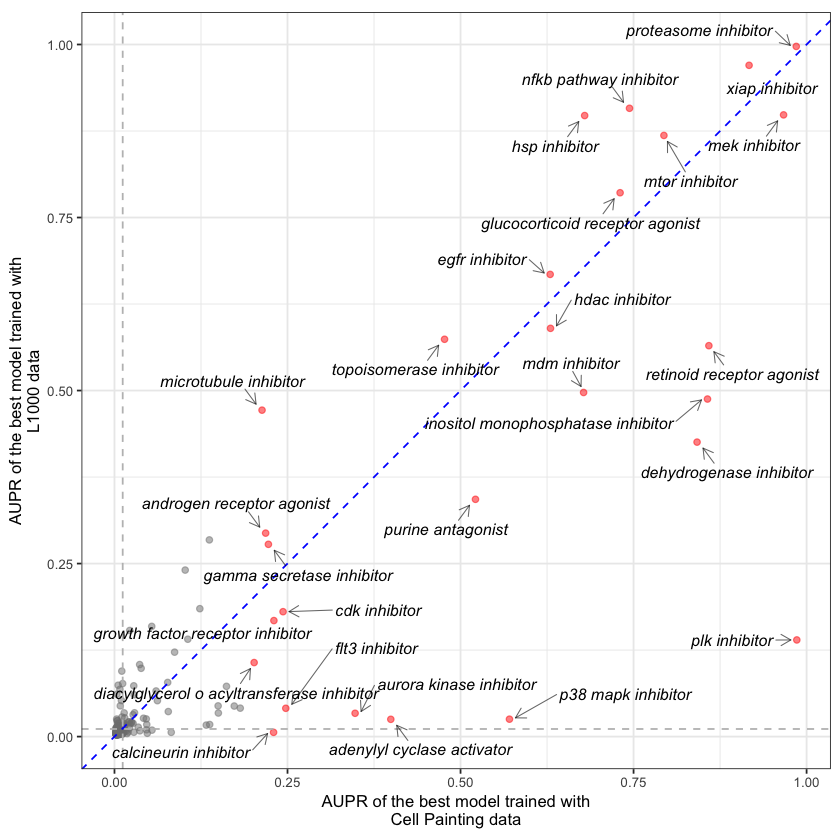

In [12]:
panel_b_gg <- (
    ggplot(moa_metrics_df, aes(x = cp_values, y = L1_values))
    + geom_point(color = ifelse(color_logic, "red", "grey50"), alpha = 0.5)
    + figure_theme
    + geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "blue")
    + xlab("AUPR of the best model trained with\nCell Painting data")
    + ylab("AUPR of the best model trained with\nL1000 data")
    + coord_fixed()
    + geom_hline(yintercept = l1000_baseline, linetype = "dashed", color = "grey")
    + geom_vline(xintercept = cp_baseline, linetype = "dashed", color = "grey")
    + geom_text_repel(
        data = subset(moa_metrics_df, color_logic),
        arrow = arrow(length = unit(0.015, "npc")),
        segment.size = 0.3,
        segment.alpha = 0.6,
        size = 3.4,
        fontface = "italic",
        box.padding = 0.5,
        point.padding = 0.5,
        aes(
            x = cp_values,
            y = L1_values,
            label = moa,
        )
    )
)

panel_b_gg

## Combine plots

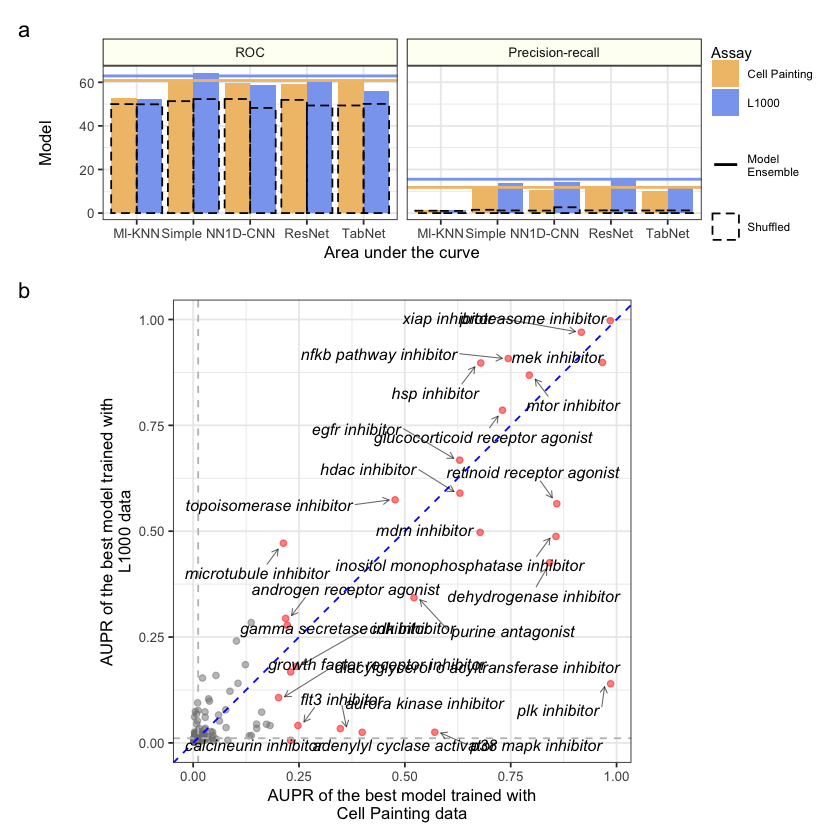

In [13]:
figure5_gg <- (
    panel_a_gg
    / panel_b_gg
    + plot_layout(
        ncol = 1,
        heights = c(1, 3),
        widths = NA
    )
    + plot_annotation(
        tag_levels = "a"
    )
)
figure5_gg

In [14]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, figure5_gg, base_width = 8, base_height = 11, dpi = 500)
}